In [2]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import lightkurve as lk

Let's download a nice star that has good time-delays -- KIC 9651065.

/Users/danielhey/Dropbox (Sydney Uni)/code/lightkurve/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


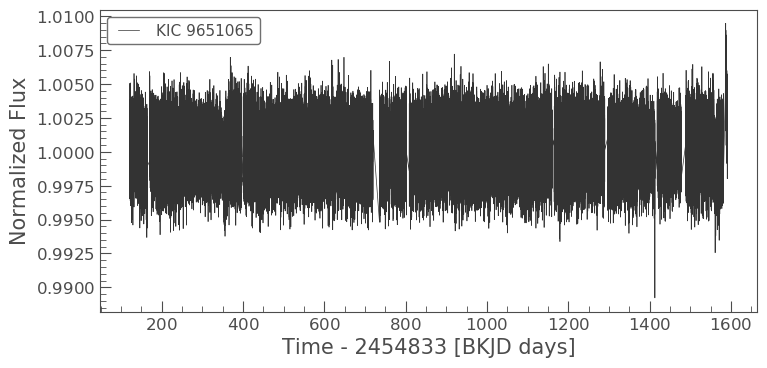

In [3]:
lc = lk.search_lightcurvefile('KIC 9651065', mission='Kepler').download_all().stitch().remove_nans()
lc.plot()

Here, we pass the time and flux data into Maelstrom. Note that lightkurve automatically subtracts the Kepler zero time (2454844 days). If you want to include additional data, you must work within the same reference time. If the `freq` argument is not specified, Maelstrom will automatically try and detect some good peaks. Be warned however, this does not always work and you should always check which frequencies you use! I have set the upper limit on the peak search to 40 cpd, since there are some Nyquist aliases. We can tell they are aliases as their time delays will match the Kepler orbital period. Neat!

First look will subdivide the lightcurve, using the old method, and provide a preliminary glance at the orbital signal. The frequencies are colored by their amplitude, and the orange line is the weighted average value. We see a nice peak around 272 d, which is the orbital period.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c22fe0400>,
      dtype=object)

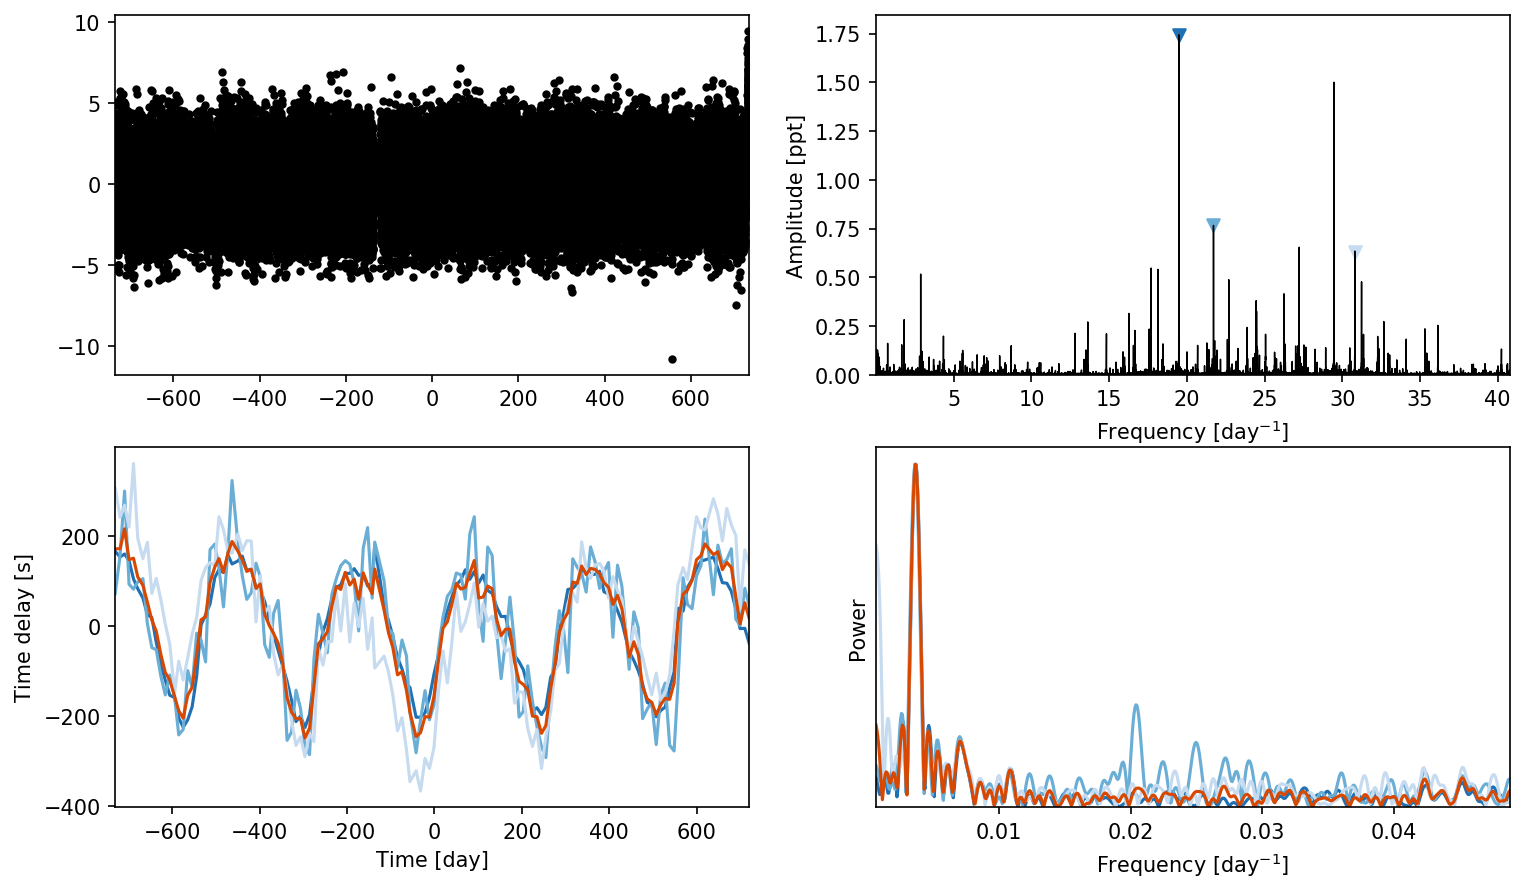

In [5]:
from maelstrom import Maelstrom

ms = Maelstrom(lc.time, lc.flux, max_peaks=3, fmin=5, fmax=40)
ms.first_look()

Let's now perform an initial optimisation..

In [6]:
ms.setup_orbit_model(period=272.)
opt = ms.optimize()

In [7]:
opt

{'logperiod': array(5.60521999),
 't0': array(62.81682186),
 'varpi_angle__': array([-3.63491287,  2.60526494]),
 'eccen_interval__': array(-0.19311827),
 'logs': array(0.21291595),
 'lighttime': array([-178.42822977, -191.38811959, -194.05396788]),
 'mean_flux': array(0.00075224),
 'W_hat_cos': array([-1.32914437, -0.73862243,  0.07306373]),
 'W_hat_sin': array([-1.16295423, -0.25908341,  0.65529972]),
 'period': array(271.84172004),
 'varpi': array(-0.94892768),
 'eccen': array(0.45187089),
 'tref': array(-15.34882925)}

Maelstrom has decided that all these frequencies belong to one star, as their lighttimes are all positive (or negative). This means the system is PB1. We can get a ready-made model from the get go by asking nicely, and passing in the optimisation results:

In [8]:
pb1_model = ms.pin_orbit_model(opt)
pb1_model

AttributeError: 'PB1Model' object has no attribute 'init_params'

As we can see, pb1_model inherits from the PyMC3 Models object. It is, by definition, a custom model which has access to all of the properties of the default Model class. This means we can do cool things like this:

In [9]:
pb1_model.print_model()

NameError: name 'pb1_model' is not defined